### Maximize Utility for Quantum Entanglement Switch 

We reproduce parts of the analytical results of [Vardoyan et al., 2023](https://ieeexplore.ieee.org/abstract/document/10313675) and compare them to our simplest simulation setup `surrogate_vardoyan_netsquid_comparison.py`. 

<img src="Images/users-server-topology.png" width="500" height="300">

A four-node, three-link topology, where user-server pairs wish to communicate. |
Settings:
- Attempt rate T = 10−3 s. 
- Links 1 and 2: 2 km long
- Link 3: varied.
- Buffer size B is unlimited for all users


In [33]:
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import pickle

font = 20
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'arial',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font
})

beta = 0.2 # attenuation in fiber
c_loss = 1 # other system losses

attempt_durations_l = [10 ** -3, 10 ** -3] # [s]

def Fidel(w):
    return (3*w+1)/4 

def D_H(w1,w2):
    F = Fidel(w1*w2)
    return 1 + F*np.log2(F) + (1-F) * np.log2((1-F)/3) if F > 0.81 else 1e-10 # yield of the so-called “hashing” protocol

def U_D(R, w1, w2): 
    val = np.log(R*D_H(w1,w2))
    return val

def Objective(x):
    R, w1, w2 = x
    return - 2*U_D(R, w1, w2) + (2*R - d_l[0]*(1-w1))**2 + (R - d_l[1]*(1-w2))**2 

res = {'Distance [km]':[], 'Server link':[], 'User link':[], 'Utility':[], 'Rate':[], 'Fidelity':[]}
for i in [1.5**k for k in np.linspace(1,11.5,15)]:
    distances_l = [i, 2] # [km]

    eta_l = 10 ** (-0.1 * beta * np.array(distances_l)/2) # transmissivity between one link end and midpoint station
    d_l = 3 * c_loss * eta_l / (2*np.array(attempt_durations_l))

    sol = minimize(Objective, x0=(75, 0.95, 0.95), bounds=( (1,80), (0.85,1.), (0.85,1.)), method='L-BFGS-B')
    rate, ws, wu = sol.x
    U = U_D(rate, ws, wu)

    res['Server link'].append(Fidel(ws))
    res['User link'].append(Fidel(wu))
    res['Utility'].append(2*U) # aggregated utility
    res['Fidelity'].append(Fidel(ws*wu))
    res['Rate'].append(rate) 
    res['Distance [km]'].append(i) 
df_res = pd.DataFrame.from_records(res)


In [34]:
df_plot = df_res.melt(id_vars=['Distance [km]', 'Fidelity', 'Rate', 'Utility'], var_name='Type', value_name='Link Fidelity')

Get simulation results: Either run `surrogate_vardoyan_netsquid_comparison.py` with seeds SEED=1,2, ..., 10 (execution time ~ 4h) or retrieve data from ... [LINK!!]

In [35]:
dfs = []
for name in glob.glob(f'../../surdata/qswitch/Sur_df*.csv'):
    with open(name,'rb') as file: dfs.append(pd.read_csv(name))

df = pd.concat(dfs, ignore_index=True)
df

,Unnamed: 0,bright_state_server,bright_state_user,Iteration,Fidelity,Fidelity_std,Rate,Rate_std,Utility,Utility_std,server_distance
0,0,0.057084,0.031510,17,0.913804,1.754492e-16,55.925,2.631522,6.402659,0.066888,1.500000
1,1,0.070441,0.030846,22,0.901611,7.531036e-17,53.235,2.996983,6.012228,0.079125,12.444444
2,2,0.067783,0.023040,24,0.911259,2.586126e-16,39.970,2.483515,5.671037,0.088715,23.388889
3,3,0.072312,0.018831,27,0.910672,8.232118e-17,33.035,2.301957,5.275180,0.100943,34.333333
4,4,0.081961,0.017005,2,0.902892,1.598238e-16,28.600,2.379560,4.797698,0.120897,45.277778
...,...,...,...,...,...,...,...,...,...,...,...
95,5,0.070304,0.012438,17,0.918424,0.000000e+00,19.905,1.843656,4.433780,0.129576,56.222222
96,6,0.073988,0.022405,29,0.905817,1.161839e-16,16.100,2.394253,3.705312,0.217522,67.166667
97,7,0.073139,0.008075,11,0.919573,1.739377e-16,12.605,1.753760,3.534304,0.201129,78.111111
98,8,0.079233,0.006789,19,0.914696,1.659739e-16,10.830,1.017553,3.132118,0.139288,89.055556


In [36]:
dfs = []
for name in glob.glob(f'../../surdata/qswitchtest/SU*.csv'):
    with open(name,'rb') as file: dfs.append(pd.read_csv(name, index_col=0))

df = pd.concat(dfs, ignore_index=True)
df

,bright_state_server,bright_state_user,Iteration,Fidelity,Fidelity_std,Rate,Rate_std,Utility,Utility_std,server_distance
0,0.081511,0.008922,27,0.910537,2.733119e-16,13.971,1.588573,3.542550,0.162884,78
1,0.059119,0.031616,23,0.911757,1.656339e-16,57.466,3.015030,6.409652,0.074485,1
2,0.079643,0.010327,39,0.911127,2.397049e-16,17.345,1.737985,3.991797,0.143244,67
3,0.077082,0.015855,13,0.908693,1.220696e-16,27.637,2.066704,4.871185,0.105806,45
4,0.076331,0.012186,42,0.912723,2.873817e-16,21.125,1.829285,4.425529,0.123465,56
5,0.078790,0.006657,1,0.915252,1.547290e-16,10.296,1.482515,3.030599,0.209736,89
6,0.070269,0.023621,35,0.908324,8.368621e-17,41.550,2.480097,5.679913,0.085621,23
7,0.078790,0.006657,1,0.915252,1.627599e-16,8.188,1.478850,2.561918,0.259026,100
8,0.078859,0.020433,34,0.902857,2.319432e-16,36.124,2.443336,5.266210,0.095357,34
9,0.064631,0.026340,26,0.911299,1.264671e-16,48.562,2.744476,6.061948,0.080028,12


Visualization

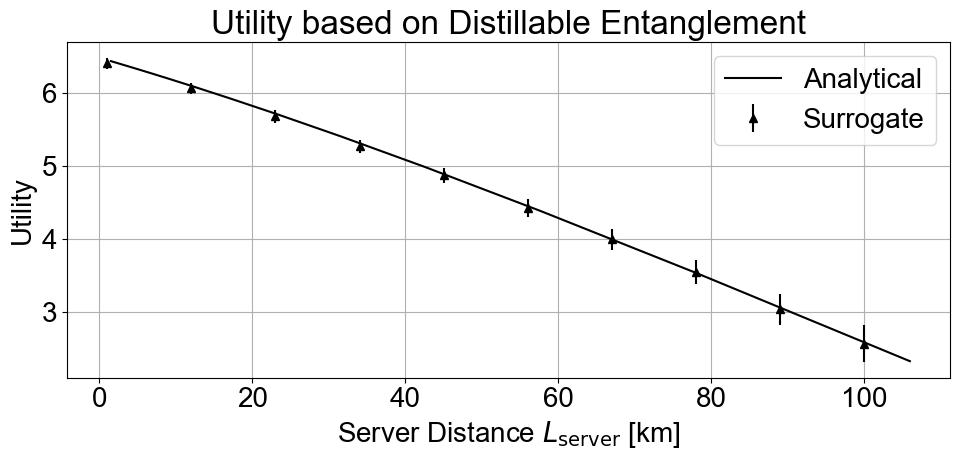

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
grouped= df.groupby('server_distance')
plt.plot(df_res['Distance [km]'], df_res['Utility'], color='black', label='Analytical')
plt.errorbar(df.server_distance, df.Utility, yerr=df.Utility_std,  fmt='^', color='black', label='Surrogate')
#plt.errorbar(grouped['Utility'].mean().index, grouped['Utility'].mean().values , grouped['Utility'].std().values, fmt='^', color='black', label='Surrogate')
plt.grid()
plt.title('Utility based on Distillable Entanglement')
plt.ylabel('Utility')
plt.xlabel(r'Server Distance $L_{\mathrm{server}}$ [km]')
plt.legend()
plt.tight_layout()
plt.savefig('Images/QES-example1-utility.pdf')

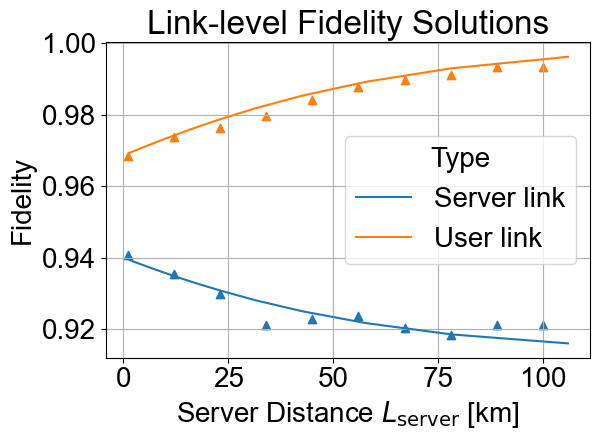

In [38]:
# plt.errorbar(grouped['bright_state_server'].mean().index, 1-grouped['bright_state_server'].mean().values , grouped['bright_state_server'].std().values, fmt='^', color='tab:blue')
# plt.errorbar(grouped['bright_state_user'].mean().index, 1-grouped['bright_state_user'].mean().values , grouped['bright_state_user'].std().values, fmt='^', color='tab:orange')
plt.scatter(df.server_distance, 1-df.bright_state_user, marker='^', color='tab:orange')
plt.scatter(df.server_distance, 1-df.bright_state_server, marker='^', color='tab:blue')
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')
plt.xlabel(r'Server Distance $L_{\mathrm{server}}$ [km]')
plt.ylabel('Fidelity')
plt.grid()
plt.title('Link-level Fidelity Solutions')
plt.tight_layout()
plt.savefig('Images/QES-example1-LinkFidelity.pdf')

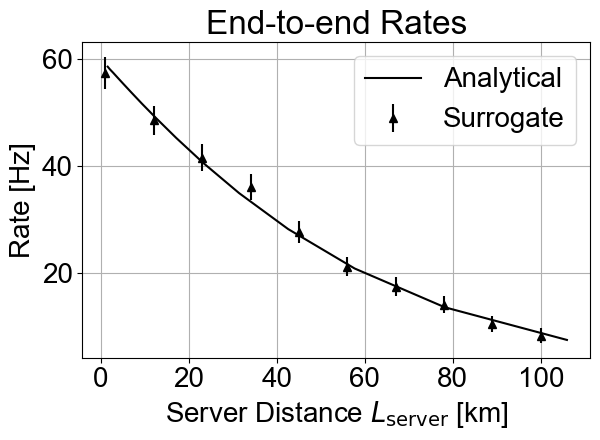

In [39]:
fig, ax1 = plt.subplots()
#plt.errorbar(grouped['Rate'].mean().index, grouped['Rate'].mean().values , grouped['Rate'].std().values, fmt='^', color='black')
plt.errorbar(df.server_distance, df.Rate, yerr=df.Rate_std,  fmt='^', color='black', label= 'Surrogate')
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True, color='black', ax=ax1, label= 'Analytical')
plt.xlabel(r'Server Distance $L_{\mathrm{server}}$ [km]')
plt.ylabel('Rate [Hz]')
plt.grid()
plt.title('End-to-end Rates')
plt.legend()
plt.tight_layout()
plt.savefig('Images/QES-example1-Rate.pdf')

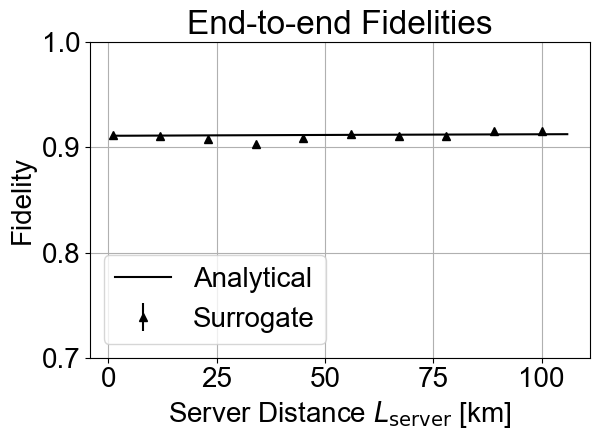

In [40]:
sns.lineplot(data=df_res, x='Distance [km]', y='Fidelity', markers=True, color='black',label= 'Analytical' )
#plt.errorbar(grouped['Fidelity'].mean().index, grouped['Fidelity'].mean().values , grouped['Fidelity'].std().values, fmt='^', color='black')
plt.errorbar(df.server_distance, df.Fidelity, yerr=df.Fidelity_std,  fmt='^', color='black', label= 'Surrogate')
plt.ylim([0.7,1])
plt.grid()
plt.xlabel(r'Server Distance $L_{\mathrm{server}}$ [km]')
plt.title('End-to-end Fidelities')
plt.legend()
plt.tight_layout()
plt.savefig('Images/QES-example1-Fidelity.pdf')

Werner states $\rho_w$ are equivalent to how we model depolarization in simulation $\rho_{depol}$:
$$\rho_{B00} = |\Psi^+><\Psi^+|$$
$$ \rho_w  = w \rho_{B00} + (1-w) \frac{I_4}{4}$$

$$\rho_{depol} = (1-\frac{3}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$ 
$$\rho_{depol} = (1-\frac{3}{4}p + \frac{1}{4}p - \frac{1}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)I\rho_{B00}I + \frac{p}{4}(I\rho_{B00}I + X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)\rho_{B00} + \frac{p}{4}I$$
$$\rightarrow w = 1-p$$

Thus, we need to set the probability of an error happening to 
$$F = \frac{3w+1}{4} = 1-\alpha$$
$$\rightarrow w = 1 - \frac{4}{3}\alpha $$
$$\rightarrow p = 4/3\alpha $$

in our depolarization-error model in fiber (take a look at`netsquid_error_model.py`). 